In [1]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# data
table = 'cleaner_5sgm_exp30m_z20.pickle'
path = '/data01/homes/dipiano/E4/irf_z20/crab/'
dataset = join(path, table)

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infofile = join(path, table.replace('.pickle', '.dat'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infofile = join(path, table.replace('.npy', '.dat'))

print(f"Classes: {ds.keys()}\n")
print(f"NOISY dataset size: {len(ds['DS1'])}")
print(f"CLEAN dataset size: {len(ds['DS2'])}")

print(ds['DS1'][0].shape)

Classes: dict_keys(['DS1', 'DS2', 'normalisation'])

NOISY dataset size: 20000
CLEAN dataset size: 20000
(200, 200)


In [2]:
from astroai.tools.utils import split_noisy_dataset

train_noisy, train_clean, test_noisy, test_clean = split_noisy_dataset(ds, split=80, reshape=True, binning=200)

print(f"Train clean: {train_clean.shape}")
print(f"Train noisy: {train_noisy.shape}")
print(f"\nTest clean: {test_clean.shape}")
print(f"Test labenoicyls: {test_noisy.shape}")

Train clean: (16000, 200, 200, 1)
Train noisy: (16000, 200, 200, 1)

Test clean: (4000, 200, 200, 1)
Test labenoicyls: (4000, 200, 200, 1)


In [3]:
infodata = pd.read_csv(infofile, sep=' ', header=0).sort_values(by=['seed'])
infodata.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
14000,crab_00001,1,0,100,100,316.641513,12.589385,316.529421,12.904256,0.333312,North_z20_S_0.5h_LST,2.5,6.472037
14001,crab_00002,2,0,100,100,16.841739,78.034907,18.877416,77.993683,0.424728,North_z20_0.5h_LST,2.5,6.277098
14002,crab_00003,3,0,100,100,340.483309,-17.472847,340.130408,-17.623667,0.368734,North_z20_S_0.5h_LST,2.5,6.194221
14003,crab_00004,4,0,100,100,344.849066,86.535858,329.619289,84.942323,1.941093,North_z20_N_0.5h_LST,2.5,6.153547
14004,crab_00005,5,0,100,100,214.863376,34.357314,216.119150,33.122741,1.616953,North_z20_N_0.5h_LST,2.5,6.129901


16239


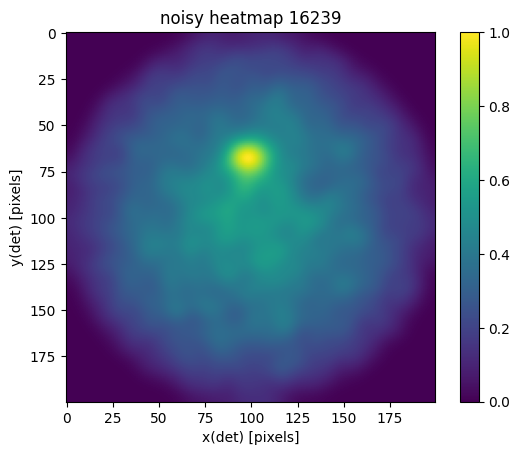

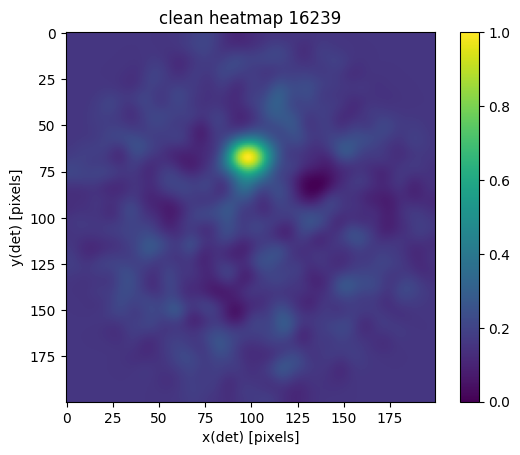

In [4]:
from astroai.tools.utils import plot_heatmap

idx = np.random.choice(range(len(test_noisy)))
idx = 238
# find seed to get the original heatmap
seed = len(train_noisy) + idx + 1
print(seed)

plot_heatmap(test_noisy[idx], title=f'noisy heatmap {seed}', show=True, save=False, save_name=None)
plot_heatmap(test_clean[idx], title=f'clean heatmap {seed}', show=True, save=False, save_name=None)

## Load model and weights

In [5]:
import tensorflow as tf

savename = 'cleaner_FINAL_5sgm_filter12_expRAND' 
model = tf.keras.models.load_model(f'../models/cnn_cleaner/{savename}.keras')
model.summary()

2024-03-23 13:57:55.614798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 13:57:55.771603: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 13:57:56.411341: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-23 13:57:56.411440: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 12)      60        
                                                                 
 average_pooling2d (AverageP  (None, 100, 100, 12)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 12)      588       
                                                                 
 average_pooling2d_1 (Averag  (None, 50, 50, 12)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 12)        588   

125/125 [==============================] - 4s 20ms/step


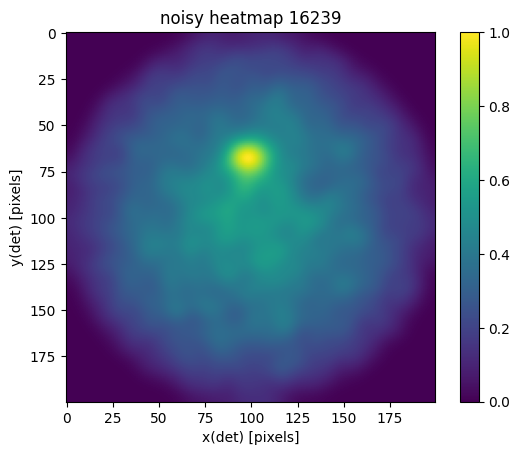

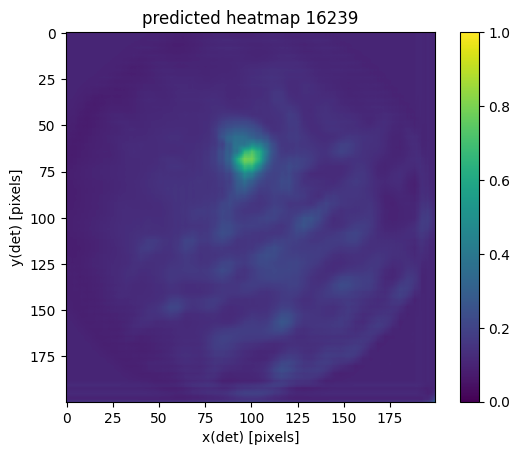

In [6]:
predictions = model.predict(test_noisy)

# plot noisy and prediction
plot_heatmap(test_noisy[idx], title=f'noisy heatmap {seed}', show=True)
plot_heatmap(predictions[idx], title=f'predicted heatmap {seed}', show=True)

# Revert normalisation

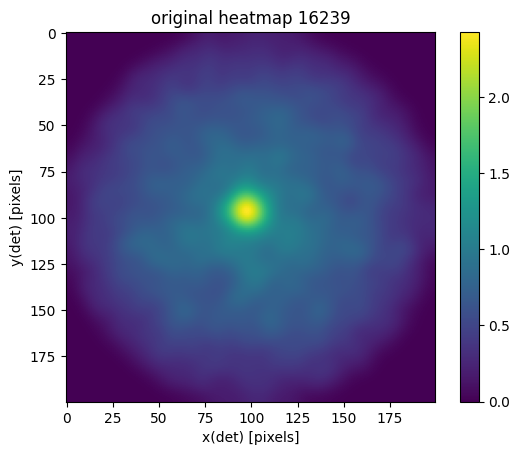

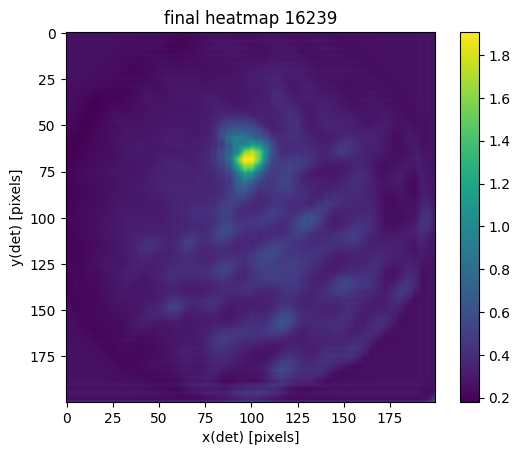

In [7]:
import numpy as np
from astropy.table import Table
from astroai.tools.utils import revert_normalise_heatmap
from astroai.tools.utils import extract_heatmap_from_table, normalise_heatmap

smooth = 5
binning = 200
original = f'/data01/homes/dipiano/E4/irf_random/crab/sim_randomEXP/crab_{seed:05d}.fits'
original_heatmap = Table.read(original, hdu=1).to_pandas()
original_heatmap = extract_heatmap_from_table(original_heatmap, trange=[0, 100], 
                                              smoothing=smooth, nbins=binning)
plot_heatmap(np.rot90(original_heatmap), title=f'original heatmap {seed}', show=True, vnorm=False)

revert_cnn_heatmap = revert_normalise_heatmap(predictions[idx], original_heatmap)
plot_heatmap(revert_cnn_heatmap, title=f'final heatmap {seed}', show=True, vnorm=False)

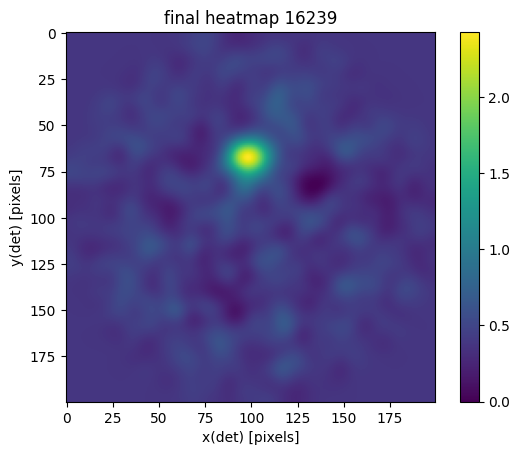

In [8]:
revert_ctools_heatmap = revert_normalise_heatmap(test_clean[idx], original_heatmap)
plot_heatmap(revert_ctools_heatmap, title=f'final heatmap {seed}', show=True, vnorm=False)

In [9]:
np.max(original_heatmap), np.max(revert_ctools_heatmap), np.max(revert_cnn_heatmap)

(2.42442278766155, 2.42442278766155, 1.9070381)

# Plot loss

In [10]:
loss = model.evaluate(test_noisy, test_clean, verbose=2)

125/125 - 3s - loss: 0.4228 - 3s/epoch - 24ms/step


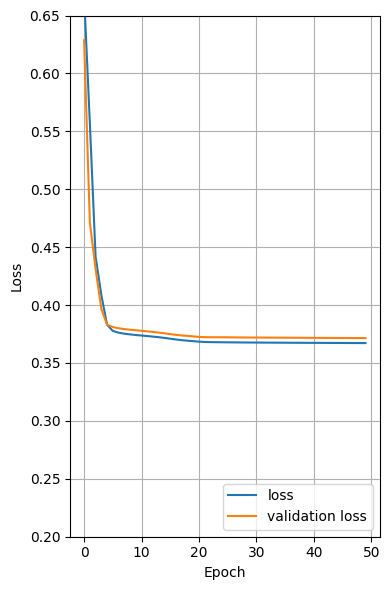

dict_keys(['loss', 'val_loss'])

In [11]:
import matplotlib.pyplot as plt

history = np.load(f'/data01/homes/dipiano/astroAI/astroai/models/cnn_cleaner/{savename}_history.npy', 
                  allow_pickle='TRUE').item()


fig, ax = plt.subplots(figsize=(4, 6))

ax.plot(history['loss'], label='loss')
ax.plot(history['val_loss'], label = 'validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_ylim([0.2,0.65])
ax.grid()
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

history.keys()

# Create SRC and PNT coordinates

In [12]:
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
2238,crab_16239,16239,0,100,100,139.843664,-67.729194,139.706353,-66.932474,0.798475,North_z20_0.5h_LST,2.5,6.149662


In [13]:
from astroai.tools.utils import set_wcs
from astropy.coordinates import SkyCoord

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)
point_ref, pixelsize

(100.0125, 0.025)

In [14]:
source_x, source_y = w.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0], 
                                               unit='deg', frame='icrs'))
point_x, point_y = w.world_to_pixel(SkyCoord(row['point_ra'].values[0], row['point_dec'].values[0], 
                                             unit='deg', frame='icrs'))

source_x, source_y, point_x, point_y

(array(96.9432513), array(67.15389765), array(99.025), array(99.025))

In [15]:
source_pix = {'ra': source_x, 'dec': source_y}
point_pix = {'ra': point_x, 'dec': point_y}
source_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
point_deg = {'ra': row['point_ra'].values[0], 'dec': row['point_dec'].values[0]}

source_pix, point_pix, source_deg, point_deg

({'ra': array(96.9432513), 'dec': array(67.15389765)},
 {'ra': array(99.025), 'dec': array(99.025)},
 {'ra': 139.84366413603752, 'dec': -67.72919436998842},
 {'ra': 139.7063532353867, 'dec': -66.93247418717661})

# Residuals

In [16]:
# clean the all DS NOISY
#ds['DS3'] = model.predict(np.concatenate((train_noisy, test_noisy)))

residuals = {'STD': [], 'CNN': []}

for noisy, clean, pred in zip(test_noisy, test_clean, predictions):
    residuals['STD'].append(noisy - clean)
    residuals['CNN'].append(noisy - pred)
    
len(residuals['STD']), len(residuals['CNN'])

(4000, 4000)

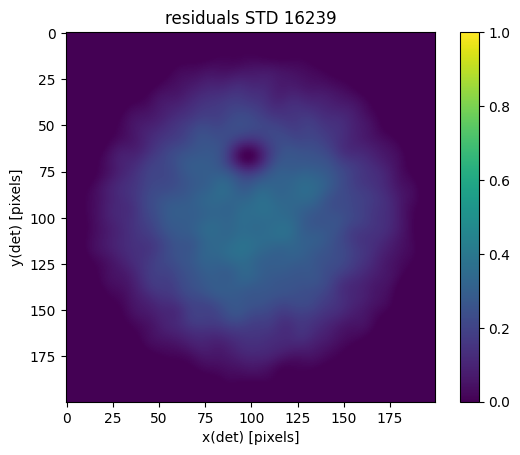

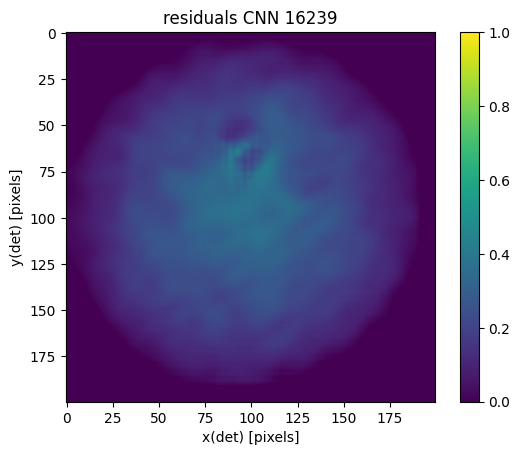

In [17]:
plot_heatmap(residuals['STD'][idx], title=f'residuals STD {seed}', show=True, vnorm=True)
plot_heatmap(residuals['CNN'][idx], title=f'residuals CNN {seed}', show=True, vnorm=True)

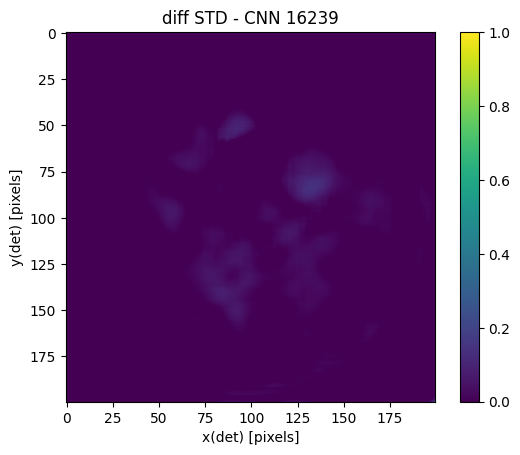

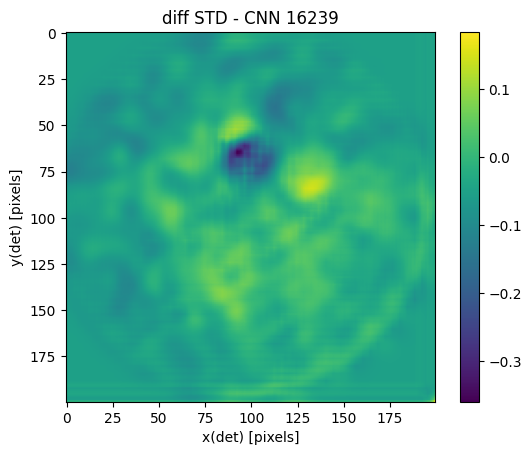

In [18]:
diff = residuals['STD'][idx] - residuals['CNN'][idx]
plot_heatmap(diff, title=f'diff STD - CNN {seed}', show=True, vnorm=True)
plot_heatmap(diff, title=f'diff STD - CNN {seed}', show=True, vnorm=False)

# Histograms on validation set

In [19]:
sum_residual = {'STD': [], 'CNN': []}
for std, cnn in zip(residuals['STD'], residuals['CNN']):
    sum_residual['STD'].append(np.sum(std))
    sum_residual['CNN'].append(np.sum(cnn))

sum_cleaned = {'STD': [], 'CNN': []}
for std, cnn in zip(test_clean, predictions):
    sum_cleaned['STD'].append(np.sum(std))
    sum_cleaned['CNN'].append(np.sum(cnn))
    
sum_original_and_diff = {'NOISY': [], 'DIFF': []}
for orig, std, cnn in zip(test_noisy, residuals['STD'], residuals['CNN']):
    sum_original_and_diff['NOISY'].append(np.sum(orig))
    sum_original_and_diff['DIFF'].append(np.sum(std - cnn))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


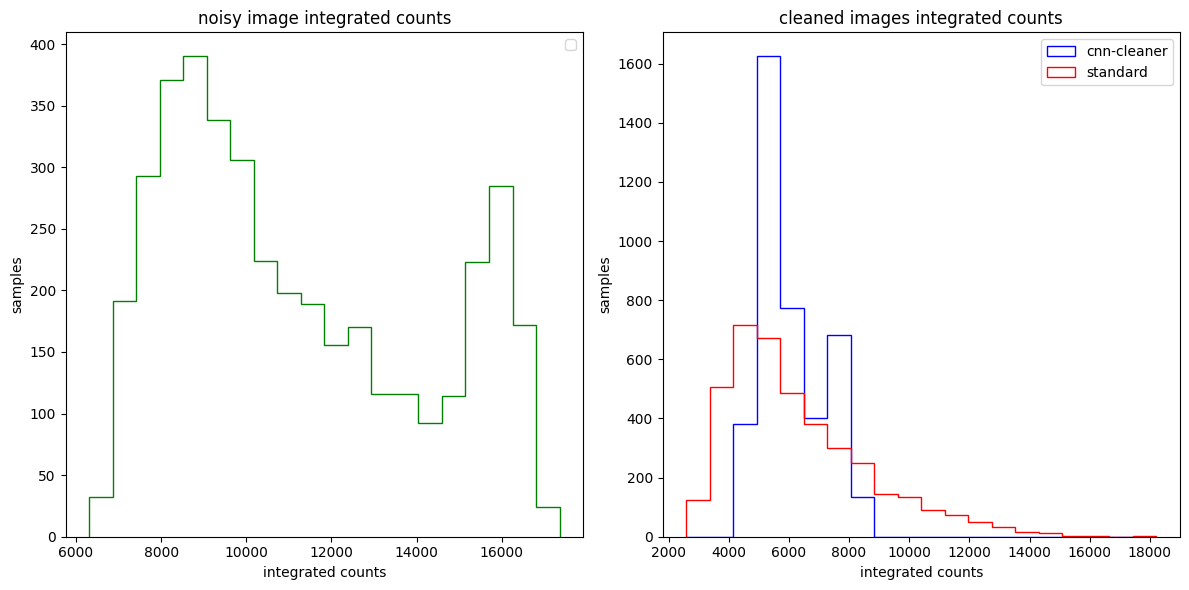

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
colors = ['red', 'blue']

# original hist
data = sum_original_and_diff['NOISY']
ax[0].set_title('noisy image integrated counts')
ax[0].hist(data, 20, density=False, histtype='step', color='green')
ax[0].set_ylabel('samples')
ax[0].set_xlabel('integrated counts')
ax[0].legend()

# cumulative counts hist
data = (sum_cleaned['STD'], sum_cleaned['CNN'])
ax[1].set_title('cleaned images integrated counts')
ax[1].hist(data, 20, density=False, histtype='step', color=colors, label=['standard', 'cnn-cleaner'])
ax[1].set_ylabel('samples')
ax[1].set_xlabel('integrated counts')
ax[1].legend()

plt.tight_layout()
plt.show()

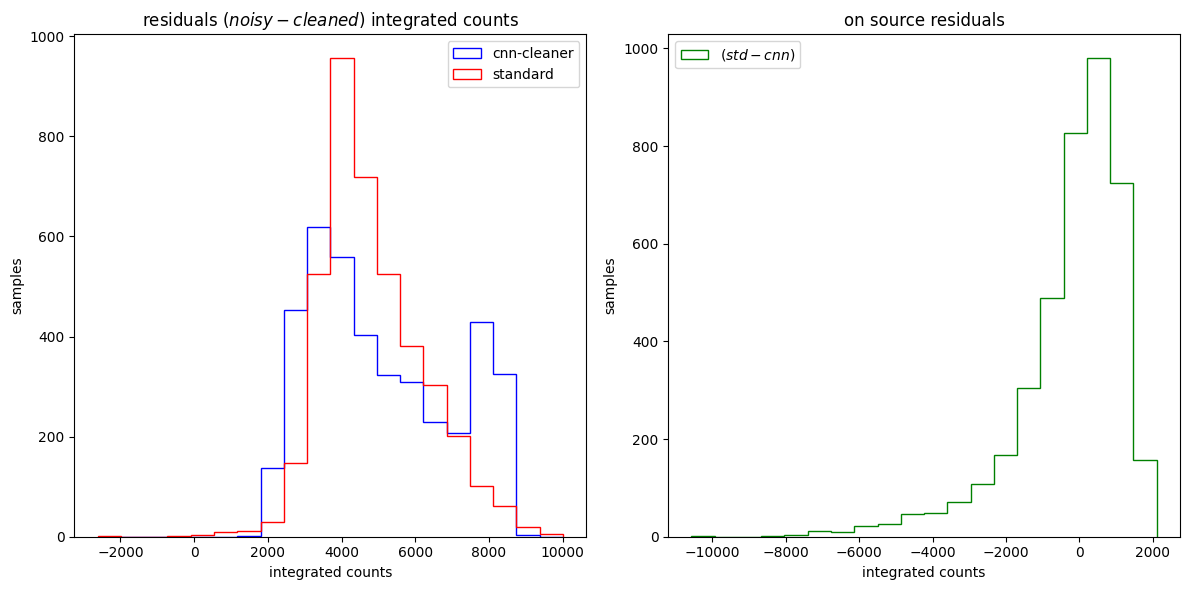

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
colors = ['red', 'blue']

# residual hist
data = (sum_residual['STD'], sum_residual['CNN'])
ax[0].set_title(r'residuals $(noisy - cleaned)$ integrated counts')
ax[0].hist(data, 20, density=False, histtype='step', color=colors, label=['standard', 'cnn-cleaner'])
ax[0].set_ylabel('samples')
ax[0].set_xlabel('integrated counts')
ax[0].legend()

# residual diff hist
data = sum_original_and_diff['DIFF']
ax[1].set_title(r'on source residuals')
ax[1].hist(data, 20, density=False, histtype='step', color='green', label=r'$(std - cnn)$')
ax[1].set_ylabel('samples')
ax[1].set_xlabel('integrated counts')
ax[1].legend(loc=2)

plt.tight_layout()
plt.show()

# extract on source counts

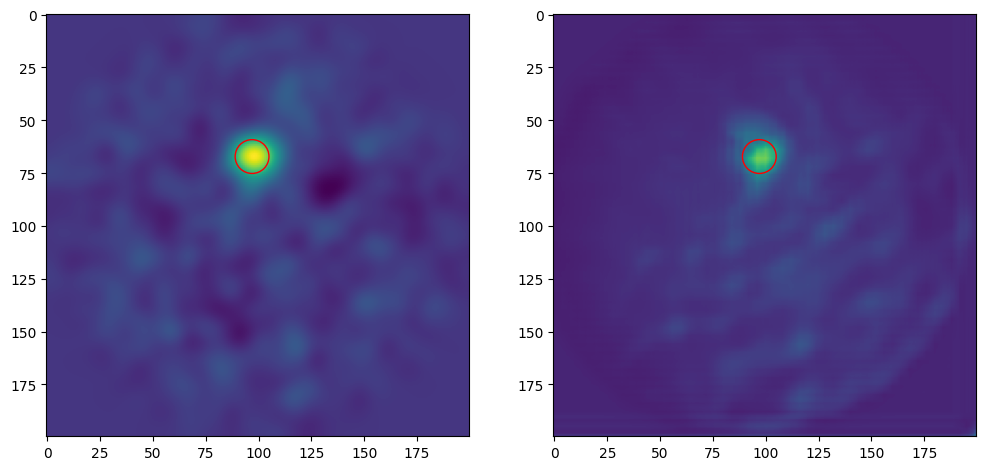

In [22]:
from matplotlib.patches import Circle

x, y = source_x, source_y
xy = source_x, source_y
radius_pix = 0.2/0.025
# on_region = Circle(xy, radius=radius_pix)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
# STD cleaning
ax[0].imshow(test_clean[idx], vmin=0, vmax=1)
ax[0].add_patch(plt.Circle(xy, radius=radius_pix, edgecolor='r', facecolor='none'))

# CNN cleaning
ax[1].imshow(predictions[idx], vmin=0, vmax=1)
ax[1].add_patch(plt.Circle(xy, radius=radius_pix, edgecolor='r', facecolor='none'))


plt.show()

# Create on source mask

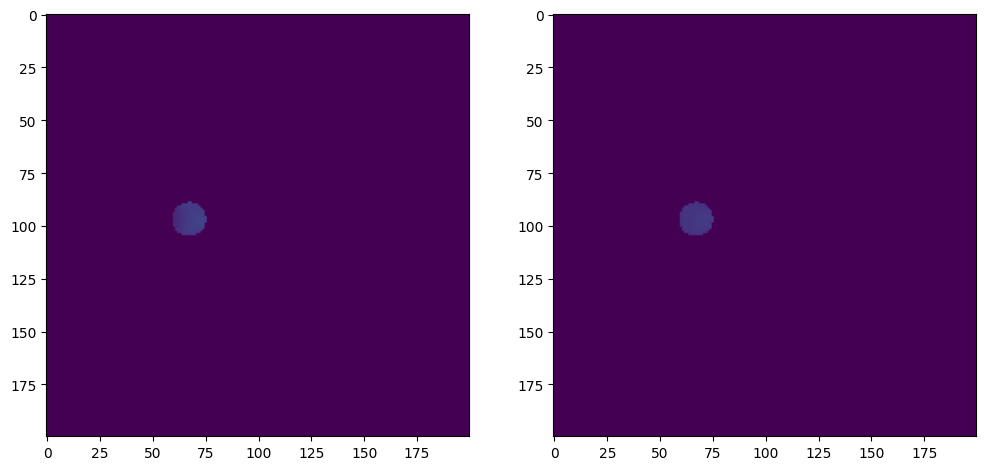

In [23]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask


fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
# STD cleaning
h, w = test_clean[idx].shape[:2]
mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
masked_img1 = test_clean[idx].copy()
masked_img1[~mask] = 0

ax[0].imshow(masked_img1, vmin=0, vmax=1)

# CNN cleaning
h, w = predictions[idx].shape[:2]
mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
masked_img2 = predictions[idx].copy()
masked_img2[~mask] = 0

ax[1].imshow(masked_img2, vmin=0, vmax=1)


plt.show()

In [24]:
np.sum(masked_img1), np.sum(masked_img2)

(33.44310546220111, 31.485016)

# Histograms on validation set

In [25]:
sum_on_region = {'STD': [], 'CNN': [], 'AP_EXCESS': [], 'DIFF': []}

s = len(train_noisy)
for std, cnn in zip(test_clean, predictions):
    s += 1 
    row = infodata[infodata['seed']==s]
    # sky coordinates
    source_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    point_deg = {'ra': row['point_ra'].values[0], 'dec': row['point_dec'].values[0]}
    # pixel coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)
    x, y = w.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0], 
                                                   unit='deg', frame='icrs'))
    # ON counts with STD cleaning
    h, w = std.shape[:2]
    mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
    masked_std = std.copy()
    masked_std[~mask] = 0

    # ON counts with CNN cleaning
    h, w = cnn.shape[:2]
    mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
    masked_cnn = cnn.copy()
    masked_cnn[~mask] = 0
    
    sum_on_region['STD'].append(np.sum(masked_std))
    sum_on_region['CNN'].append(np.sum(masked_cnn))
    #sum_on_region['AP_EXCESS'].append(dl3_ph['excess'])
    sum_on_region['DIFF'].append(np.sum(masked_std - masked_cnn))
    


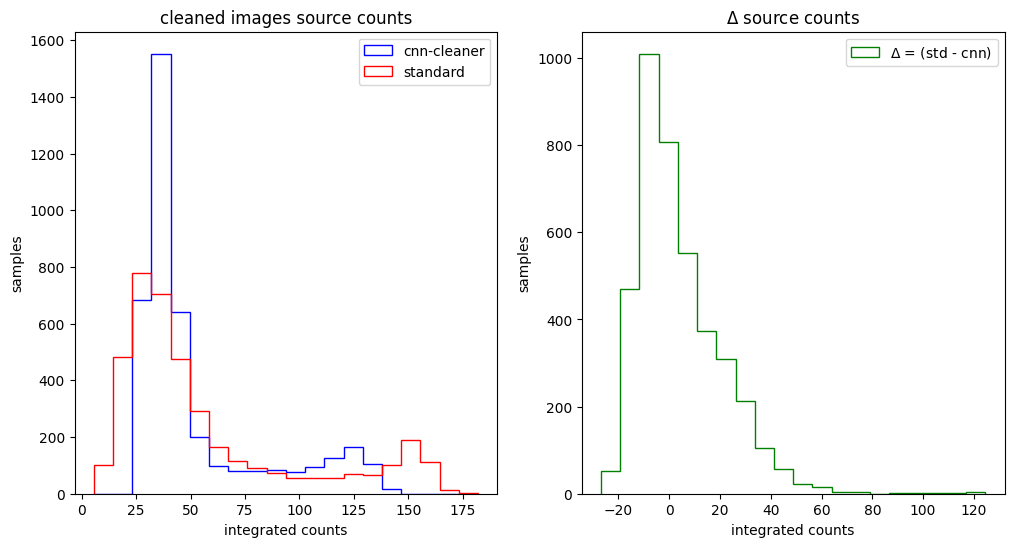

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
colors = ['red', 'blue'] #, 'black'

# cumulative counts hist
data = (sum_on_region['STD'], sum_on_region['CNN']) #, sum_on_region['AP_EXCESS']
ax[0].set_title('cleaned images source counts')
ax[0].hist(data, 20, density=False, histtype='step', color=colors, label=['standard', 'cnn-cleaner'])
ax[0].set_ylabel('samples')
ax[0].set_xlabel('integrated counts')
ax[0].legend()

# residual hist
data = sum_on_region['DIFF']
ax[1].set_title(r'$\Delta$ source counts')
ax[1].hist(data, 20, density=False, histtype='step', color='green', label=r'$\Delta$ = (std - cnn)')
ax[1].set_ylabel('samples')
ax[1].set_xlabel('integrated counts')
ax[1].legend() 

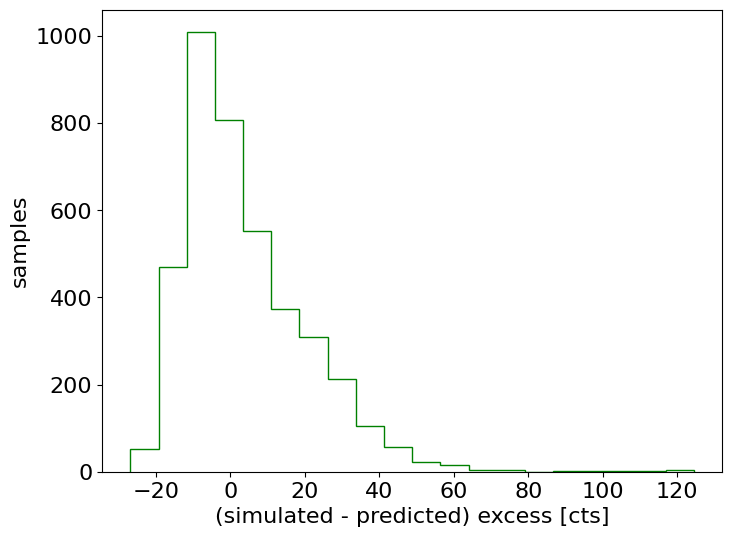

In [27]:
fs = 16

plt.figure(figsize=(8, 6))
ax = plt.subplot()
data = sum_on_region['DIFF']
#ax.set_title(r'$\Delta$ source signal')
ax.hist(data, 20, density=False, histtype='step', color='green')
ax.set_ylabel('samples', fontsize=fs)
ax.set_xlabel('(simulated - predicted) excess [cts]', fontsize=fs)
ax.tick_params(axis='both', labelsize=fs)